In [63]:
## additional plots for gerhard
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
# API settings
api_url = '/services/data/v43.0/sobjects'
external_id = 'Name'
object_id = 'ContactToolAssociation__c'

# login parameters to be handled by Papermill
sql_login_params = {"username": "wang2506_ro", "password": "fnVnwcCS7iT45EsA"}
sf_login_params = {
    "grant_type": "password",
    "client_id": "3MVG95jctIhbyCppj0SNJ75IsZ1y8UPGZtSNF4j8FNVXz.De8Lu4jHm3rjRosAtsHy6qjHx3i4S_QbQzvBePG",
    "client_secret": "D1623C6D3607D4FC8004B92C761DFB6C1F70CCD129C5501E357028DFA00F5764",
    "username":"wang2506@purdue.edu",
    "password":"purdue99272844vp8Z6qq0teuPQmirGaaPAt4",   
} 
    #"username": "wang159-4j1v@force.com",
    #"password": "napoleon0eZ3PQpQqE3C3z4wWqEqKGhQ8",

In [10]:
import sys
sys.path.append('/home/users/wang2506/nanohub_salesforce_integ/salesforce')
    
import pandas as pd
import time
import datetime

from DB2SalesforceAPI import DB2SalesforceAPI

## plots
### 1. unique institutions in classes per 12 month period 
### 2. unique institutions in unclassified users per 12 month period
### 3. cumulative line of classes

### unique institutions in classes per 12 mo period (calc'd by prev month)

In [11]:
db_1 = DB2SalesforceAPI(sf_login_params)

Obtained Salesforce access token ...... True


In [12]:
tool_cluster_df = db_1.query_data('Select ID, Ending_Date__c, Starting_Date__c, Organization__c from tool_usage_cluster__c')

[Success] Bulk job creation successful. Job ID = 7505w00000ToMNfAAN
{"id":"7505w00000ToMNfAAN","operation":"query","object":"tool_usage_cluster__c","createdById":"0055w00000DM5bOAAT","createdDate":"2021-02-01T04:23:03.000+0000","systemModstamp":"2021-02-01T04:23:03.000+0000","state":"UploadComplete","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","retries":0,"totalProcessingTime":0}
{"id":"7505w00000ToMNfAAN","operation":"query","object":"tool_usage_cluster__c","createdById":"0055w00000DM5bOAAT","createdDate":"2021-02-01T04:23:03.000+0000","systemModstamp":"2021-02-01T04:23:07.000+0000","state":"JobComplete","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","numberRecordsProcessed":3949,"retries":0,"totalProcessingTime":741}
[Success] Bulk job completed successfully.


In [18]:
display(tool_cluster_df.head(5))
print(tool_cluster_df.shape)

,Ending_Date__c,Id,Organization__c,Starting_Date__c
0,2011-01-30,a0w5w000009Q7CuAAK,NaN,2010-09-05
1,2018-11-30,a0w5w000009Q7CvAAK,a0r5w00000V42iyAAB,2018-11-29
2,2019-11-28,a0w5w000009Q7CwAAK,a0r5w00000V42iyAAB,2019-11-04
3,2017-10-29,a0w5w000009Q7CxAAK,a0r5w00000V42cCAAR,2017-10-21
4,2018-01-21,a0w5w000009Q7CyAAK,a0r5w00000V42cCAAR,2018-01-15


(3949, 4)


In [19]:
## pull the list of contacts within each cluster
contacts_in_cluster_df = db_1.query_data('Select Contact__c, Tool_Usage_Cluster__c from ContactToolClusterAssociation__c')

[Success] Bulk job creation successful. Job ID = 7505w00000ToMT3AAN
{"id":"7505w00000ToMT3AAN","operation":"query","object":"ContactToolClusterAssociation__c","createdById":"0055w00000DM5bOAAT","createdDate":"2021-02-01T04:26:49.000+0000","systemModstamp":"2021-02-01T04:26:49.000+0000","state":"UploadComplete","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","retries":0,"totalProcessingTime":0}
{"id":"7505w00000ToMT3AAN","operation":"query","object":"ContactToolClusterAssociation__c","createdById":"0055w00000DM5bOAAT","createdDate":"2021-02-01T04:26:49.000+0000","systemModstamp":"2021-02-01T04:26:58.000+0000","state":"JobComplete","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","numberRecordsProcessed":79007,"retries":0,"totalProcessingTime":3898}
[Success] Bulk job completed successfully.


In [20]:
display(contacts_in_cluster_df.head(5))
print(contacts_in_cluster_df.shape)

,Contact__c,Tool_Usage_Cluster__c
0,0035w000034K5BgAAK,a0w5w000009Q7lKAAS


(1, 2)


In [ ]:
# concludes data imports from SF

In [23]:
## do four years
import datetime
now = datetime.datetime.strptime('2021-01-15','%Y-%m-%d')#datetime.datetime.now()
earliest_mo = now-datetime.timedelta(days=365*4)
print(now)
print(earliest_mo)

2021-01-15 00:00:00
2017-01-16 00:00:00


In [24]:
earliest_date = '{year}-{month}-{day}'.format(year=earliest_mo.year, month = earliest_mo.month, day = earliest_mo.day)
earliest_date = datetime.datetime.strptime(earliest_date,'%Y-%m-%d')
print(earliest_date)

2017-01-16 00:00:00


In [25]:
mo = datetime.timedelta(days=30) #assume each month lasts 30 days

In [26]:
mo_construct = int(365*4/30)+1 #now we do 4 years

# build dataframe
monthly_df = pd.DataFrame(columns=['Month Start','Number_Unique_Institutions'])

In [28]:
# build month start
month_start = []

for i,j in enumerate(range(mo_construct-1)):
    if i == 0:
        temp = earliest_date+mo
    else:
        temp += mo
    temp_string = '{year}-{month}-{day}'.format(year=temp.year, month = temp.month, day = temp.day)
    month_start.append(temp_string)    
    
print(month_start[:2])
print(month_start[-2:])

['2017-2-15', '2017-3-17']
['2020-11-26', '2020-12-26']


In [29]:
monthly_df['Month Start'] = month_start
monthly_df['Number_Unique_Institutions'] = 0
display(monthly_df.head(2))

,Month Start,Number_Unique_Institutions
0,2017-2-15,0
1,2017-3-17,0


In [39]:
#create backup for safety
from copy import deepcopy
new_df = deepcopy(tool_cluster_df)
new_df = new_df.dropna()
display(new_df.head(2))

,Ending_Date__c,Id,Organization__c,Starting_Date__c
1,2018-11-30,a0w5w000009Q7CvAAK,a0r5w00000V42iyAAB,2018-11-29
2,2019-11-28,a0w5w000009Q7CwAAK,a0r5w00000V42iyAAB,2019-11-04


In [41]:
# search 
clusters_in_month = {}
year = datetime.timedelta(days=365)

for i,j in enumerate(month_start):
    clusters_in_month_inner = []
    
    # convert to datetime
    ms_dt = datetime.datetime.strptime(j,'%Y-%m-%d') #month starting date
    
    org_list = [] #to keep track of unique orgs
    
    # iterate through dataframe
    for k,h in enumerate(new_df['Starting_Date__c'].to_list()): 
        # case 1 ()[], case 2 []()
        end_date_dt = datetime.datetime.strptime(new_df.iloc[k,0],'%Y-%m-%d')
        start_date_dt = datetime.datetime.strptime(h,'%Y-%m-%d')
        
        # exclude () [] or [] () - end_date_dt < (ms_dt - year) or start_date_dt > (ms_dt)
        if end_date_dt >= (ms_dt-year) and start_date_dt <= ms_dt:
        # demorgan's law end_date_dt < ws_dt or start_date_dt > (ws_dt+week): 
            # add information to weekly_df
            #weekly_df.iloc[i,2] += new_df.iloc[k,1] ## this guy double counted
            #monthly_df.iloc[i,3] += 1
        
            org_list.append(new_df.iloc[k,-2])
            
            clusters_in_month_inner.append(new_df.iloc[k,-3])
            
    org_list = set(org_list)
    monthly_df.iloc[i,1] = len(org_list)
    clusters_in_month[i] = clusters_in_month_inner

In [43]:
display(monthly_df.head(2))
display(monthly_df.tail(2))

,Month Start,Number_Unique_Institutions
0,2017-2-15,96
1,2017-3-17,96


,Month Start,Number_Unique_Institutions
46,2020-11-26,137
47,2020-12-26,134


Text(0, 0.5, 'Unique Institutions')

<Figure size 432x288 with 0 Axes>

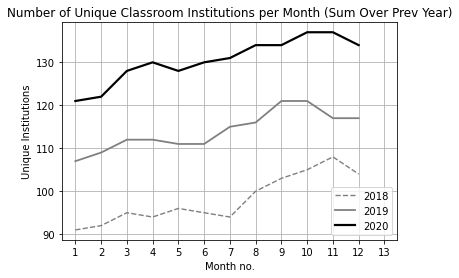

In [70]:
## plot
# each year is 12 months
month_count = range(1,13)
unique_classes = monthly_df['Number_Unique_Institutions'].to_list()

year_1 = unique_classes[-36:-24]
year_2 = unique_classes[-24:-12]
year_3 = unique_classes[-12:]

plt.figure('monthly_unique_institutions_classes')

fig,ax = plt.subplots()
ax.plot(month_count,year_1,color='grey',linestyle='dashed',label='2018',linewidth=1.4)
ax.plot(month_count,year_2,color='grey',label='2019',linewidth=1.8)
ax.plot(month_count,year_3,color='black',label='2020',linewidth=2.2)
ax.legend()
ax.grid(which='both')
ax.set_xlim([0.5,13.5])
ax.set_xticks(np.arange(1,14,1))
# print(plt.xticklabels())

ax.set_title('Number of Unique Classroom Institutions per Month (Sum Over Prev Year)')
ax.set_xlabel('Month no.')
ax.set_ylabel('Unique Institutions')
# plt.savefig('monthly_institutions.png',dpi=500,transparent=True)
# plt.savefig('monthly_institutions2.png',dpi=500)

### Total classes over all time

In [51]:
# for ease of reference
display(tool_cluster_df.head(2))

,Ending_Date__c,Id,Organization__c,Starting_Date__c
0,2011-01-30,a0w5w000009Q7CuAAK,NaN,2010-09-05
1,2018-11-30,a0w5w000009Q7CvAAK,a0r5w00000V42iyAAB,2018-11-29


In [ ]:
# first find the earliest date in the start_date__c category
# increment in monthly tabs

In [53]:
sf_start_dates = tool_cluster_df['Starting_Date__c'].to_list()
sf_earliest = datetime.datetime.strptime(sf_start_dates[0],'%Y-%m-%d') 

for i,j in enumerate(sf_start_dates):
    j = datetime.datetime.strptime(j,'%Y-%m-%d') 
    
    sf_start_dates[i] = j
    
    if j < sf_earliest: 
        sf_earliest = deepcopy(j)
print(sf_earliest)

2000-10-03 00:00:00


In [59]:
# increment yearly
max_months = 20*12+2 #20 years and 2 months
class_date_tracker = []

class_temp_tracker = 0
for i in range(max_months):

    if i == 0:
        current_earliest = sf_earliest
    else:
        current_earliest = current_earliest + datetime.timedelta(days=30)
        
    next_dates = current_earliest + datetime.timedelta(days=30)
    
    for j in sf_start_dates:
        if j >= current_earliest and j < next_dates:
            class_temp_tracker += 1
    
    class_date_tracker.append(class_temp_tracker)
    
print(class_date_tracker[:5])

[4, 5, 5, 8, 8]


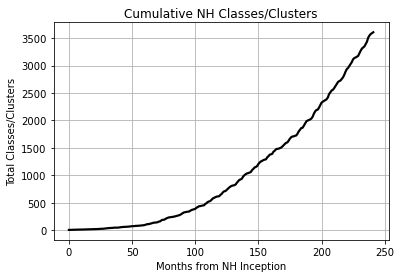

In [62]:
## plot
# each year is 12 months
month_count = range(max_months)

plt.figure('cumulative_classes')

plt.plot(month_count,class_date_tracker,color='black',linewidth=2.2)
# plt.legend()
plt.grid(which='both')
# plt.xlim([0.5,12.5])
# plt.xticks(np.arange(1,13,1))

plt.title('Cumulative NH Classes/Clusters')
plt.xlabel('Months from NH Inception')
plt.ylabel('Total Classes/Clusters')
plt.savefig('cumulative_clusters.png',dpi=500,transparent=True)
plt.savefig('cumulative_clusters2.png',dpi=500)

### graveyard

In [ ]:
earliest_string = '{year}-{month}-{day}'.format(year=earliest_mo.year, month = earliest_mo.month, day = earliest_mo.day)
earliest_date = datetime.datetime.strptime(earliest_string,'%Y-%m-%d')

In [ ]:
row_indexes = []
starting = tool_cluster_df['Starting_Date__c'].to_list()

# ensure that dates from SF exceed
for i,j in enumerate(starting):
    j = datetime.datetime.strptime(j,'%Y-%m-%d')
    
    if j >= earliest:
        row_indexes.append(i)

print(len(row_indexes))